## Load packages

In [1]:
import numpy as np
import pandas as pd
import math
from keras import optimizers
from keras import layers
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras import callbacks

import keras.backend as K
import tensorflow as tf
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix, classification_report

import geopandas as gpd
%matplotlib inline

Using TensorFlow backend.


In [2]:
# set number of cores to 8
# K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=8, 
#                                                    inter_op_parallelism_threads=8)))

## Load dataset

In [3]:
# import Matt's 'chr1_ukb_X.npz' file
chr1_ukb_X = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')
# create dict mapping from sampleid to population name
sampleid_to_population_pandas_df = pd.read_csv('/home/jsokol/Data/igsr_samples_cleaned_version.tsv', delimiter="\t")
sampleid_to_population_dict = sampleid_to_population_pandas_df.set_index('Sample name')['Population code'].to_dict()
# remove samples from chr1_ukb_X that are not in dict or that do not contain value
temp = set()
for x in np.nditer(chr1_ukb_X['S']):
    sample_id = str((x.item(0))).replace("'", "").replace("b", "").split("_")[0]
    if sample_id not in sampleid_to_population_dict:
        print(sample_id + ' is not in dict. Make sure to remove this sample from the dataset.')
    elif sampleid_to_population_dict[sample_id] == float('nan'):
        print(sample_id + ' maps to nan in dict')
chr1_ukb_X_G = chr1_ukb_X['G'][:,:,:]
chr1_ukb_X_V = chr1_ukb_X['V'][:,:]
# flatten input data
X_all_data = chr1_ukb_X_G.reshape(chr1_ukb_X_G.shape[0], -1).T

In [4]:
# create dict mapping from sample to population
populations_represented_set = set()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    populations_represented_set.add(sampleid_to_population_dict[sample_id])
# print total number of populations represented by dataset
n_classes = len(populations_represented_set)
print('Total number of classes minus classes deleted because they are admixed = ' + str(n_classes))
print(populations_represented_set)

Total number of classes minus classes deleted because they are admixed = 26
{'TSI', 'IBS', 'GIH', 'PUR', 'PJL', 'JPT', 'CHS', 'PEL', 'STU', 'ESN', 'GBR', 'KHV', 'ASW', 'GWD', 'CHB', 'CLM', 'CEU', 'FIN', 'BEB', 'ACB', 'MXL', 'CDX', 'ITU', 'LWK', 'YRI', 'MSL'}


In [5]:
# create dict mapping from population to coordinate tuple
pop_info_df=pd.read_csv('/home/jsokol/Data/igsr_population_coordinates.tsv', sep='\t')
pop_info_df['coordinate_tuples'] = tuple(zip(pop_info_df['Population latitude'], pop_info_df['Population longitude']))
pop_to_coordinate_dict = pop_info_df.set_index('Population code')['coordinate_tuples'].to_dict()

In [6]:
# create 'Y_all_data' matrix containing labels
Y_all_data = np.zeros((2, 5008))
indices_to_delete = list()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    Y_all_data[0,i] = pop_to_coordinate_dict[sampleid_to_population_dict[sample_id]][0]
    Y_all_data[1,i] = pop_to_coordinate_dict[sampleid_to_population_dict[sample_id]][1]
# delete samples with unwanted classes using 'indices_to_delete'
X_all_data = np.delete(X_all_data, indices_to_delete, 1)
Y_all_data = np.delete(Y_all_data, indices_to_delete, 1)
# rescale the longitudes and latitudes
Y_all_data[1,:] = (Y_all_data[1,:]/180)
Y_all_data[0,:] = (Y_all_data[0,:]/90)

In [7]:
# randomly shuffle the order of the data
randomize = np.arange(X_all_data.shape[1])
np.random.shuffle(randomize)
X_all_data = X_all_data[:,randomize]
Y_all_data = Y_all_data[:,randomize]

In [8]:
# split data into training and test sets
X_train = X_all_data[:,:int(X_all_data.shape[1]*0.8)]
X_test = X_all_data[:,int(X_all_data.shape[1]*0.8):]
Y_train = Y_all_data[:,:int(X_all_data.shape[1]*0.8)]
Y_test = Y_all_data[:,int(X_all_data.shape[1]*0.8):]
# convert to correct format for use in keras
X_train = X_train[:,:,np.newaxis]
X_train = np.transpose(X_train, (1, 0, 2))
X_test = X_test[:,:,np.newaxis]
X_test = np.transpose(X_test, (1, 0, 2))
Y_train = np.transpose(Y_train, (1, 0))
Y_test = np.transpose(Y_test, (1, 0))

## Build model

In [9]:
def model2(n_snps_per_sample):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=(n_snps_per_sample, 1))

    # First convolutional block
    X = Conv1D(filters=49, kernel_size=500 ,strides=500, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Second convolutional block
    X = Conv1D(49, 75, strides = 5, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling1D(2, name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1127, activation='relu')(X)
    X = Dense(20, activation='relu')(X)
    X = Dense(2, activation='tanh', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model2')
    
    return model

## Create and compile the model 

In [10]:
# create model
model2 = model2(X_train.shape[1])
# compile model
adam_optimizer_fn = optimizers.Adam(lr=0.0001, amsgrad=False)
# haversine loss
def haversine_loss(y, y_hat):
    return tf.math.asin(K.sqrt((K.sin(0.5*(y[:,0]-y_hat[:,0])*np.pi))**2 + K.cos((y[:,0])*np.pi)*K.cos((y_hat[:,0])*np.pi)*(K.sin(0.5*(y[:,1]-y_hat[:,1])*np.pi)**2)))
    
model2.compile(optimizer=adam_optimizer_fn, loss='mean_squared_error', metrics=['mean_squared_error']) 
# summarize model
model2.summary()
print('Learning rate = ' + str(K.eval(model2.optimizer.lr)))

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 231504, 1)         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 463, 49)           24549     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 463, 49)           196       
_________________________________________________________________
activation_1 (Activation)    (None, 463, 49)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 93, 49)            180124    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 93, 49)            196       
_________________________________________________________________
activation_2 (Activation)    (None, 93, 49)            0    

## Train model

In [11]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = model2.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100000, batch_size = 1, callbacks = [es])




Train on 4006 samples, validate on 1002 samples
Epoch 1/100000
4006/4006 [==============================] - 109s 27ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.0913 - val_mean_squared_error: 0.0913
Epoch 2/100000
4006/4006 [==============================] - 106s 26ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 3/100000
4006/4006 [==============================] - 105s 26ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 4/100000
4006/4006 [==============================] - 137s 34ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 5/100000
4006/4006 [==============================] - 125s 31ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 6/100000
4006/4006 [==============================] - 115s 29ms/step - loss: 0.0078 - mean_

KeyboardInterrupt: 

In [ ]:
# 1) create loss and accuracy plots
_, train_acc = model2.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model2.evaluate(X_test, Y_test, verbose=0)
# 1.1) plot loss during training
pyplot.figure(1, (9,9))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
print('train mse:', train_acc)
print('test mse:', test_acc)

In [12]:
# re-scale longitudes and latitudes
Y_pred = model2.predict(X_test, verbose=1)
Y_test[:,1] = Y_test[:,1]*180 
Y_test[:,0] = Y_test[:,0]*90
Y_pred[:,1] = Y_pred[:,1]*180
Y_pred[:,0] = Y_pred[:,0]*90

1002/1002 [==============================] - 1s 1ms/step


In [13]:
# display a sample of predictions and ground truths 
np.set_printoptions(suppress=True) # to suppress numbers being displayed in their scientific form
print('Sample ground truths: ')
print(Y_test)
print(' ')
print('Sample predictions: ')
print(Y_pred)

Sample ground truths: 
[[  10.78      106.68    ]
 [  13.09       80.27    ]
 [   9.06666     7.483333]
 ...
 [   7.4         3.92    ]
 [  34.0544   -118.2439  ]
 [  60.17       24.93    ]]
 
Sample predictions: 
[[ 21.235235  102.51417  ]
 [ 21.987389   73.88827  ]
 [ 10.1109295  -2.3723836]
 ...
 [  6.0749884   7.5637918]
 [  8.51633   -75.13618  ]
 [ 54.600517    9.514018 ]]


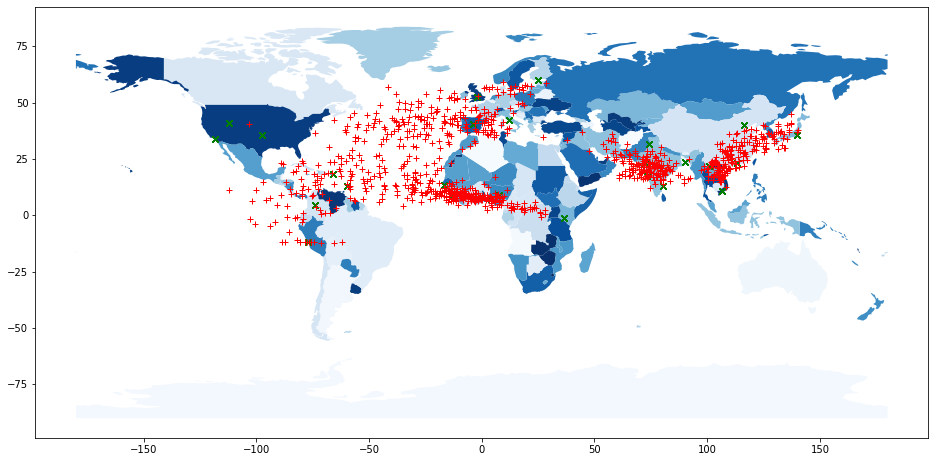

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# centroids = world.centroid
# centroid_list = pd.concat([world.name, centroids], axis=1)
# Plot the results
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
base.plot(Y_test[:,1], Y_test[:,0], 'gx')
base.plot(Y_pred[:,1], Y_pred[:,0], 'r+')
# centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 5)